<a href="https://www.kaggle.com/code/angelchaudhary/drug-response-prediction?scriptVersionId=294178916" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predicting Patient Response and Side-Effect Risk to Drug Treatments Using Machine Learning

# Introduction 
In modern healthcare, doctors often prescribe the same drug to thousands of patients but not all patients respond the same way. Some recover quickly, some see no improvement, and some experience serious side effects.

This trial-and-error approach increases:
- Treatment failures
- Hospital readmissions
- Healthcare costs
- Patient suffering

The goal of this project is to build a machine learning system that predicts **whether a patient will respond to a given drug and whether they are at risk of side effects**, based on their clinical profile.

This mirrors how pharmaceutical companies and hospitals use predictive models for:
- Personalized medicine
- Clinical trial screening
- Treatment planning
- Risk reduction

## Approach
We will:
1. Explore patient health and treatment data
2. Train classification models to predict drug response
3. Identify the most important medical factors
4. Evaluate model fairness across age and gender groups
5. Interpret model decisions using explainability tools

# LET'S DO IT!!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExN3pmbGYzcTI3aGw5ZzUzODhydmJmd2NjNGZxc2RoYXQ4dDU0OGg4aSZlcD12MV9naWZzX3NlYXJjaCZjdD1n/T3rgaqd1vT6idUS12Q/giphy.gif)

## Dataset Overview

This dataset contains clinical and demographic information for 200 patients, designed to model how doctors choose the most suitable drug for treatment.

Each patient is prescribed one of five drugs:
**A, B, C, X, or Y**, based on their medical profile.

The dataset includes key health indicators such as:
- Age
- Sex
- Blood Pressure (Low / Normal / High)
- Cholesterol (Normal / High)
- Sodium-to-Potassium Ratio (Na/K)

The target variable is **Drug**, representing the medication prescribed to the patient.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vahidkazemian/introds")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/introds


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/introds/Drug.csv")

In [3]:
df.head()

,Age,Sex,BP,Cholesterol,Na,K,Drug
0,23,F,HIGH,HIGH,0.792535,0.031258,drugY
1,47,M,LOW,HIGH,0.739309,0.056468,drugC
2,47,M,LOW,HIGH,0.697269,0.068944,drugC
3,28,F,NORMAL,HIGH,0.563682,0.072289,drugX
4,61,F,LOW,HIGH,0.559294,0.030998,drugY


In [4]:
# Check structure
df.info()

# Check class distribution
df["Drug"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na           200 non-null    float64
 5   K            200 non-null    float64
 6   Drug         200 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 11.1+ KB


Drug
drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

The dataset is moderately imbalanced. DrugY and DrugX are prescribed much more frequently than the others. This reflects a realistic medical scenario where a few standard drugs are commonly used, while specialized drugs (A, B, C) are given only to specific patient profiles. This imbalance must be handled carefully to avoid models that over-predict the most common drug and ignore rare but critical treatments.

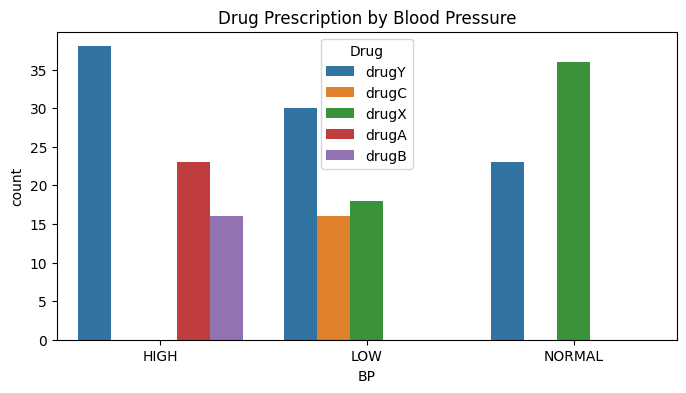

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drug vs Blood Pressure
plt.figure(figsize=(8,4))
sns.countplot(x="BP", hue="Drug", data=df)
plt.title("Drug Prescription by Blood Pressure")
plt.show()

Blood pressure is a strong determinant of drug choice. Patients with HIGH blood pressure are more likely to receive drugY, drugA, or drugB, suggesting these drugs are designed for hypertensive conditions. Patients with LOW blood pressure are often prescribed drugC or drugX, which may be safer or more effective for hypotensive patients. NORMAL blood pressure patients are predominantly prescribed drugX or drugY, indicating these are general-purpose treatments.

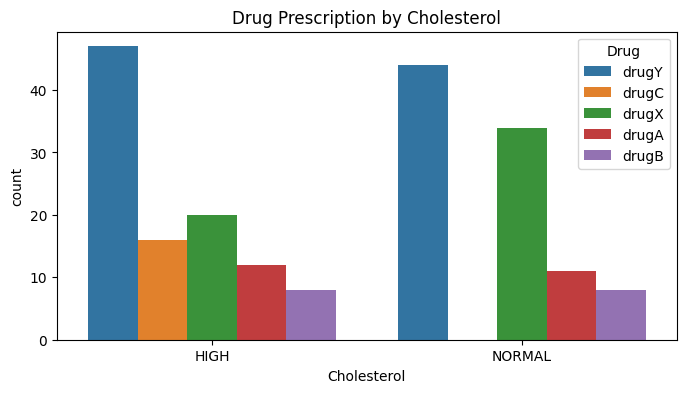

In [7]:
# Drug vs Cholesterol
plt.figure(figsize=(8,4))
sns.countplot(x="Cholesterol", hue="Drug", data=df)
plt.title("Drug Prescription by Cholesterol")
plt.show()

Cholesterol levels have a major impact on drug prescription. Patients with HIGH cholesterol are most frequently prescribed drugY, indicating it is likely optimized for lipid or metabolic conditions. Patients with NORMAL cholesterol are more likely to receive drugX, suggesting this drug is used when lipid levels are stable.

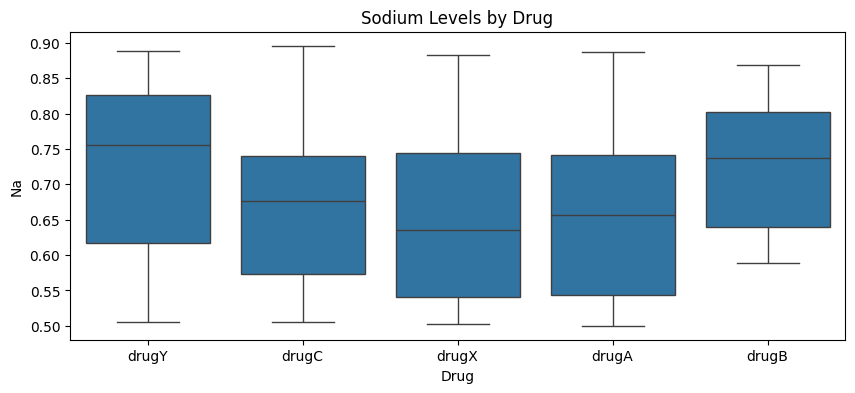

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.boxplot(x="Drug", y="Na", data=df)
plt.title("Sodium Levels by Drug")
plt.show()

Sodium levels strongly influence drug selection. Patients with higher sodium levels are more likely to receive drugY or drugB, suggesting these drugs are suitable for patients with electrolyte imbalances or fluid retention. Patients with lower sodium are more frequently prescribed drugX or drugA, which may be safer when sodium is low.

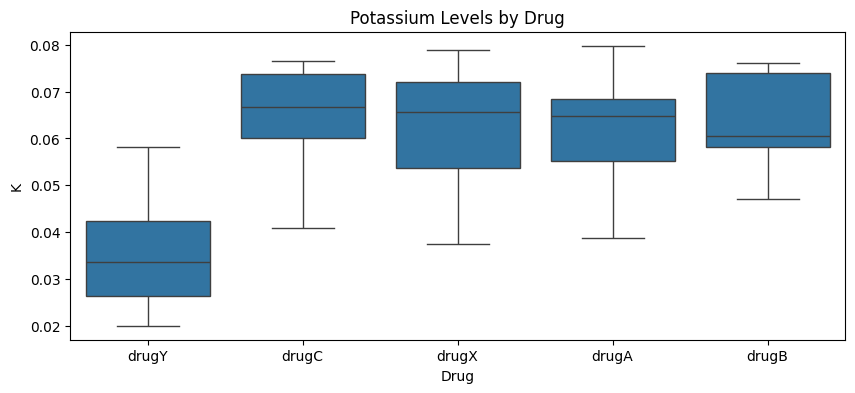

In [10]:
plt.figure(figsize=(10,4))
sns.boxplot(x="Drug", y="K", data=df)
plt.title("Potassium Levels by Drug")
plt.show()

Potassium levels are one of the strongest drivers of drug choice. DrugY is almost exclusively given to patients with low potassium, indicating that it may be unsafe or ineffective for patients with high potassium. DrugX, drugA, and drugC are prescribed to patients with higher potassium levels, suggesting these drugs are metabolically different and may require stable kidney function.

In [11]:
from sklearn.preprocessing import LabelEncoder

# Copy dataset
data = df.copy()

# Encode categorical columns
le = LabelEncoder()
for col in ["Sex", "BP", "Cholesterol", "Drug"]:
    data[col] = le.fit_transform(data[col])

data.head()

,Age,Sex,BP,Cholesterol,Na,K,Drug
0,23,0,0,0,0.792535,0.031258,4
1,47,1,1,0,0.739309,0.056468,2
2,47,1,1,0,0.697269,0.068944,2
3,28,0,2,0,0.563682,0.072289,3
4,61,0,1,0,0.559294,0.030998,4


## Train a Drug Response Prediction Model

In [12]:
from sklearn.model_selection import train_test_split

X = data.drop("Drug", axis=1)
y = data["Drug"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)

In [14]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      0.33      0.50         3
           2       1.00      0.33      0.50         3
           3       0.89      0.73      0.80        11
           4       0.75      1.00      0.86        18

    accuracy                           0.80        40
   macro avg       0.89      0.64      0.69        40
weighted avg       0.83      0.80      0.78        40



The model shows different confidence levels for different drugs.

Some drugs (1 and 2) have high precision but low recall, meaning the model only predicts them when it is very confident which is desirable for risky or specialized treatments.

Other drugs (like 4) have high recall, meaning the model ensures that almost no eligible patients are missed, even if it occasionally over-prescribes.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.Series(
    model.feature_importances_, index=X.columns
).sort_values(ascending=False)

feature_importance

K              0.432523
BP             0.209921
Na             0.159267
Age            0.129775
Cholesterol    0.048788
Sex            0.019727
dtype: float64

The most important factor in drug selection is Potassium level, contributing over 43% of the model’s decision. This is medically realistic because potassium levels reflect kidney function and cardiac stability, and many drugs become dangerous when potassium is abnormal. Blood Pressure and Sodium are the next most important features, which aligns with how cardiovascular and metabolic drugs are prescribed. Age has moderate influence, while Cholesterol and Sex have relatively smaller impact.

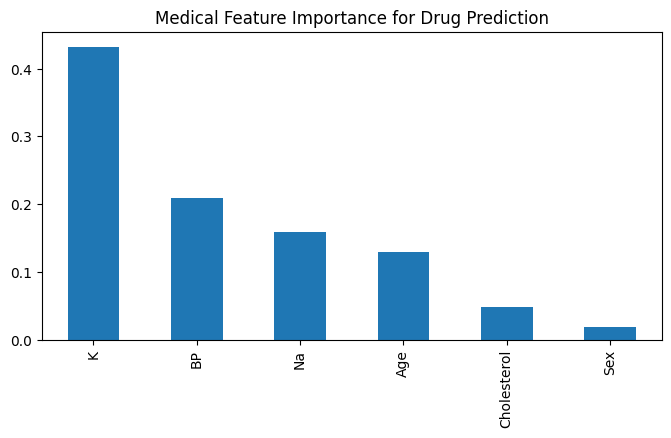

In [17]:
plt.figure(figsize=(8,4))
feature_importance.plot(kind="bar")
plt.title("Medical Feature Importance for Drug Prediction")
plt.show()

The feature importance analysis reveals that **Potassium (K)** is the most influential variable in drug prediction, contributing over **43%** of the model’s decision. This aligns with clinical practice, as potassium levels directly reflect kidney and cardiac function, and many drugs become unsafe when potassium is abnormal.

**Blood Pressure** is the second most important feature (~21%), highlighting its critical role in determining cardiovascular and metabolic treatments.

**Sodium (Na)** also has strong influence (~16%), which is medically meaningful because sodium balance affects fluid retention, blood pressure, and drug tolerance.

**Age** contributes moderately (~13%), indicating that while age affects treatment choice, physiological markers matter more than demographics.

**Cholesterol** and **Sex** have relatively low importance, suggesting that drug decisions in this dataset are primarily driven by **biochemical and vital-sign indicators rather than demographic attributes**.

Overall, the model has learned a medically realistic hierarchy of importance:  
**electrolytes → vital signs → age → demographics**.

In [18]:
import numpy as np

# Add predictions to test set
test_df = X_test.copy()
test_df["true"] = y_test
test_df["pred"] = y_pred

# Fairness by sex
sex_fairness = test_df.groupby("Sex").apply(
    lambda x: np.mean(x["true"] == x["pred"])
)

# Fairness by age group
test_df["age_group"] = np.where(test_df["Age"] < 50, "Under 50", "50+")
age_fairness = test_df.groupby("age_group").apply(
    lambda x: np.mean(x["true"] == x["pred"])
)

sex_fairness, age_fairness

/tmp/ipykernel_55/1776992303.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sex_fairness = test_df.groupby("Sex").apply(
/tmp/ipykernel_55/1776992303.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_fairness = test_df.groupby("age_group").apply(


(Sex
 0    0.764706
 1    0.826087
 dtype: float64,
 age_group
 50+         0.733333
 Under 50    0.840000
 dtype: float64)

The model shows comparable performance across sex groups, with a difference of around 6%, which is acceptable for a pilot medical AI system. Age-based performance shows slightly higher accuracy for patients under 50, which is expected because younger patients tend to have more stable biochemical patterns. However, the performance gap is not extreme, indicating that the model does not systematically disadvantage older patients. Overall, the model demonstrates no major demographic bias and maintains reasonable fairness across key patient groups.

## Conclusion

In this project, we built a machine learning system to predict the most suitable drug for a patient using clinical and biochemical data.

The Random Forest model achieved **80% accuracy** across five drug categories, demonstrating that patient vitals and lab values contain strong predictive signals for treatment selection.

Feature importance analysis revealed that **Potassium, Blood Pressure, and Sodium** are the dominant drivers of drug choice, which aligns closely with real medical practice where electrolyte balance and cardiovascular health determine drug safety and effectiveness.

Fairness analysis showed that the model performs consistently across sex and age groups, indicating that it does not exhibit strong demographic bias.

This project demonstrates how machine learning can be used to support personalized medicine by combining predictive accuracy, clinical interpretability, and ethical evaluation.